## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [45]:
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')
df_group_daily = data.groupby(['group','date']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}).reset_index().rename(columns={'user_id':'user_count', 'purchase':'purchase_sum', 'price':'price_sum'})
print(data.groupby('group').agg({'date':['min','max']}))

            date           
             min        max
group                      
A     2021-01-02 2021-01-24
B     2021-01-02 2021-01-24


Index(['user_id', 'date', 'group', 'purchase', 'price'], dtype='object')

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [50]:
df_group = data.groupby('group').agg({'user_id':'count', 'purchase':'sum','price':'sum'})
df_group['price'] = df_group['price']/(10**6)
df_group

,user_id,purchase,price
group,,,
A,147202,17723,1436.26
B,147276,17514,1554.10


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?




In [55]:
data_a = data[data['group']=='A']
data_b = data[data['group']=='B']
print(data_a['user_id'].isin(data_b['user_id']).value_counts())
user_intersection = set(data_a['user_id'])&set(data_b['user_id'])
user_intersection

False    145307
True       1895
Name: user_id, dtype: int64


{843786,
 868364,
 737298,
 843797,
 630805,
 843802,
 761882,
 933918,
 688167,
 827432,
 835630,
 860206,
 778288,
 843832,
 802877,
 745536,
 663619,
 680003,
 811077,
 811079,
 639059,
 720982,
 630871,
 835673,
 835675,
 630887,
 721002,
 761965,
 639090,
 819318,
 786565,
 778375,
 712853,
 868503,
 934040,
 671902,
 811196,
 934076,
 770242,
 917708,
 680144,
 811222,
 893145,
 631008,
 712930,
 852215,
 778488,
 884985,
 901376,
 663810,
 827654,
 917767,
 688390,
 942353,
 860441,
 745756,
 721188,
 917799,
 942375,
 844083,
 721208,
 680251,
 655678,
 704832,
 835905,
 696642,
 803145,
 639310,
 844114,
 737626,
 827741,
 942436,
 704870,
 754022,
 909678,
 786808,
 909688,
 639366,
 737675,
 844173,
 680343,
 778649,
 885146,
 639386,
 770459,
 713119,
 639407,
 803248,
 917936,
 737712,
 754102,
 795063,
 688568,
 647609,
 917949,
 901567,
 647615,
 762307,
 778692,
 680390,
 696791,
 745943,
 664025,
 664030,
 844263,
 811497,
 836084,
 655860,
 680436,
 778743,
 918023,
 

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [56]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

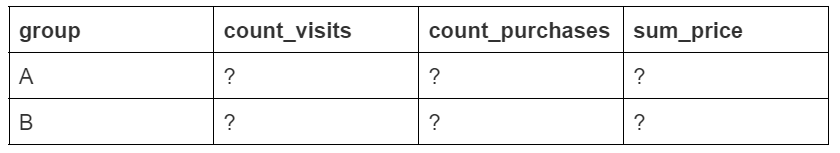
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.



Чему на этот раз равно количество посещений сайта в группах А и B?


In [57]:
df_group = updated_data.groupby(['group']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}).reset_index().rename(columns={'user_id':'count_visits', 'purchase':'count_purchases', 'price':'sum_price'})
df_group

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Можно говорить о сбалансированности выборок, потому что количество респондентов практически одинаково.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [59]:
df_group['conversion'] = round(df_group['count_purchases']/df_group['count_visits'] * 100,2)
df_group['mean_check'] = round(df_group['sum_price']/df_group['count_purchases'])
df_group

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

На предварительном этапе конверсия в группе А больше, чем в группе B, средний чек в группе В больше, чем в группе А

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [70]:
df_pivot = pd.pivot_table(updated_data, index='group',columns='price', values='purchase',aggfunc='sum')
df_pivot

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,0,5182,5271,1832,3478,1724
B,0,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

<AxesSubplot:xlabel='price', ylabel='group'>

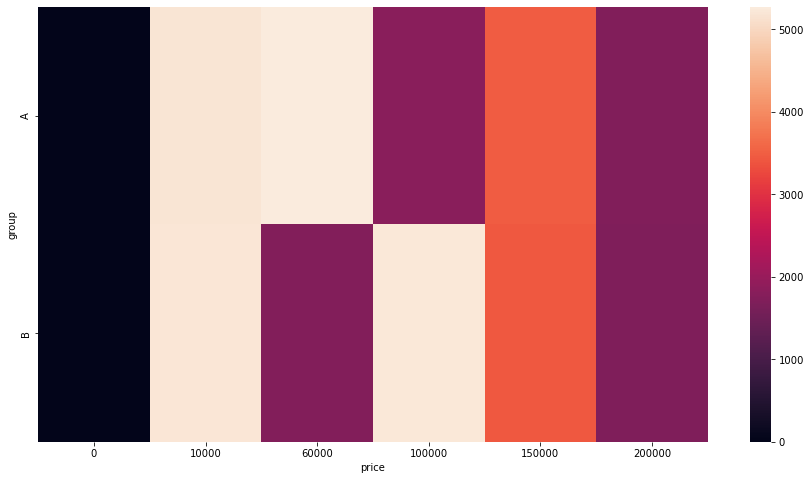

In [67]:
plt.figure(figsize=(15, 8))
sns.heatmap(df_pivot)

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

По турам за 60т рублей покупательская способность участников группы А выше, чем В. Обратная тенденция с турами за 100т рублей

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [72]:
df_group_daily = updated_data.groupby(['group','date']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}).reset_index().rename(columns={'user_id':'user_count', 'purchase':'purchase_count', 'price':'price_sum'})
df_group_daily['conversion'] = round(df_group_daily['purchase_count']/df_group_daily['user_count']*100,2)
df_group_daily['mean_check'] = round(df_group_daily['price_sum']/df_group_daily['purchase_count'])
df_group_daily

,group,date,user_count,purchase_count,price_sum,conversion,mean_check
0,A,2021-01-02,2854,359,29410000,12.58,81922.0
1,A,2021-01-03,6596,748,62000000,11.34,82888.0
2,A,2021-01-04,6566,799,64250000,12.17,80413.0
3,A,2021-01-05,6433,790,64550000,12.28,81709.0
4,A,2021-01-06,6606,764,63410000,11.57,82997.0
5,A,2021-01-07,6579,795,67290000,12.08,84642.0
6,A,2021-01-08,6687,798,65380000,11.93,81930.0
7,A,2021-01-09,6633,794,65610000,11.97,82632.0
8,A,2021-01-10,6659,759,58950000,11.40,77668.0
9,A,2021-01-11,6699,797,58760000,11.90,73726.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [ ]:
# ваш код здесь

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

In [ ]:
# ваш код здесь

ваши выводы здесь

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [ ]:
# ваш код здесь

Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

ваши выводы здесь

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [ ]:
# ваш код здесь

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [ ]:
# ваш код здесь

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [ ]:
ваши выводы здесь

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 